#XSVS analysis

In [1]:
import skxray.core.xsvs as xsvs
#import skxray.core.xsvs_fitting as xsvs_fit
import skxray.core.roi as roi
import skxray.core.correlation as corr
import skxray.core.utils as core

import numpy as np
import os, sys

import matplotlib.pyplot as plt
%matplotlib notebook
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm

<IPython.core.display.Javascript object>


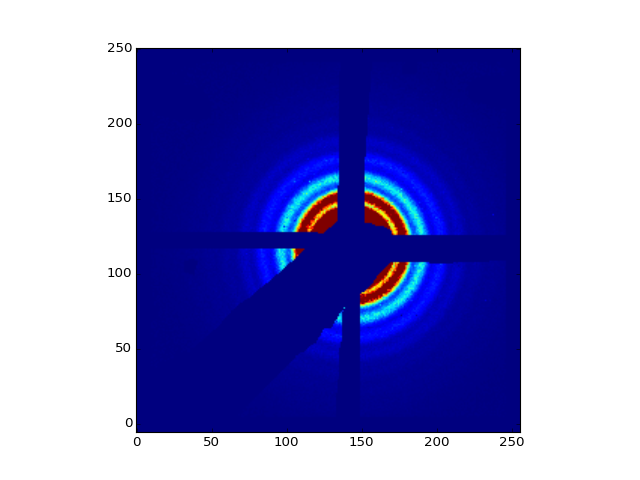

In [2]:
data_dir = "/Volumes/Data/BeamLines/CHX/Luxi_description_files_for_duke/duke_cc_12C/"
duke_ndata = np.load(data_dir+"duke_img_1_5000.npy")
duke_dark = np.load(data_dir+"duke_dark.npy")

duke_data = []
for i in range(duke_ndata.shape[0]):
    duke_data.append(duke_ndata[i] - duke_dark)
    
duke_data=np.asarray(duke_data)

avg_img = np.average(duke_data, axis=0)

mask4 = np.load("/Users/sameera/Desktop/XSVS/new_mask4.npy")
mask = np.load("/Users/sameera/Desktop/XSVS/Luxi_data/Luxi_duke_mask.npy")
# ad a colorbar, title   
# mask must be multipled !!
N_mask = (~mask * ~mask4)
#or N_mask = ~(mask + mask4)
fig,axes = plt.subplots()
axes.imshow(N_mask*avg_img, vmax=1e0)
#axes.set_title("Random Data")
axes.set_yticks([0,50,100,150,200,250])
axes.set_yticklabels([250, 200, 150, 100, 50, 0])
plt.show()
#plt.imshow(N_mask*avg_img, vmax=1e0)
#plt.yticks([0,50,100,150,200,250])
#plt.yticklabels([250, 200, 150, 100, 50, 0])
#plt.show()

<IPython.core.display.Javascript object>


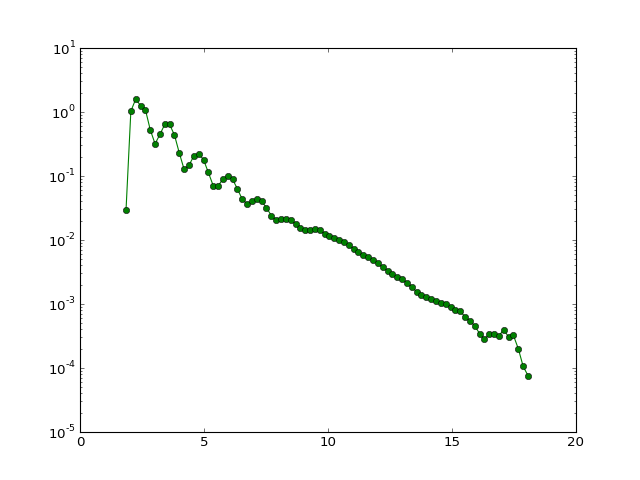

In [3]:
est_center = (133, 143)   

inner_radius = 25
width = 5
var = 20

bin_centers, ring_averages= roi.circular_average(avg_img*N_mask, est_center, threshold=0, nx=100,
                                         pixel_size=(0.1, 0.1))
line_color="green"
line_style='o'
plt.figure()
plt.semilogy(bin_centers, ring_averages, c=line_color, marker=line_style )

plt.show()

<IPython.core.display.Javascript object>


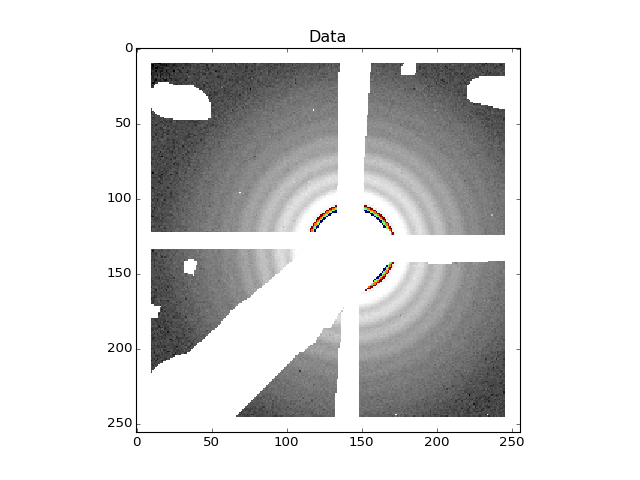

In [6]:
inner_radius = 26
width = 1
spacing = 0
num_rings = 4

edges = roi.ring_edges(inner_radius, width, spacing, num_rings)

rings = roi.rings(edges, (133, 143), avg_img.shape)

rings_mask = rings*N_mask

mask_data1 = N_mask*duke_data[0:2655]
mask_data2 = N_mask*duke_data[2659:4999]

def test_demo(ax, label_array, img_dim, image):
    """
    This will plot the reqiured roi's on the image
    """

    vmin, vmax = np.percentile(image, [100, 100])
    #im = ax.imshow(tt.reshape(*img_dim), cmap='Paired', interpolation='nearest')
    im = ax.imshow(image, cmap='gist_gray', interpolation='none', norm=LogNorm(), vmax=1e0)
    im = ax.imshow(label_array, interpolation='none', norm=LogNorm())
    #im = ax.imshow(image, interpolation='none',  vmax=1e0)
    
#  get the avearge image of the data set
avg_img = np.average(mask_data1, axis=0)
    
fig, ax = plt.subplots()
plt.title("Data")
test_demo(ax, rings_mask, avg_img.shape, avg_img)
plt.show()


# Convert to q (the ring values)

In [7]:
dpix =0.055

lambda_ = 1.5498  # wavelength
Ldet = 2200.   #   # distance to sample

edges

array([[ 26.,  27.],
       [ 27.,  28.],
       [ 28.,  29.],
       [ 29.,  30.]])

In [8]:
two_theta = core.radius_to_twotheta(Ldet, edges*dpix)
q_val = core.twotheta_to_q(two_theta, lambda_)
q_val

array([[ 0.00263522,  0.00273658],
       [ 0.00273658,  0.00283793],
       [ 0.00283793,  0.00293929],
       [ 0.00293929,  0.00304064]])

In [9]:
q_cen = np.mean(q_val, axis=1)
q_cen

array([ 0.0026859 ,  0.00278726,  0.00288861,  0.00298997])

In [10]:
from __future__ import absolute_import, division, print_function
import logging
import time

import numpy as np

import skxray.core.utils as core

logger = logging.getLogger(__name__)


def xsvs2(image_sets, label_array, mean_int_rois, timebin_num=2, number_of_img=50,
          max_cts=None):
    """
    This function will provide the probability density of detecting photons
    for different integration time.

    The experimental probability density P(K) of detecting photons K is
    obtained by histogramming the photon counts over an ensemble of
    equivalent pixels and over a number of speckle patterns recorded
    with the same integration time T under the same condition.

    Parameters
    ----------
    image_sets : dict
        sets of images

    label_array : array
        labeled array; 0 is background.
        Each ROI is represented by a distinct label (i.e., integer).

    timebin_num : int, optional
        integration times

    number_of_img : int, optional
        number of images

    max_cts : int, optional
       the brightest pixel in any ROI in any image in the image set.

    Returns
    -------
    prob_k_all : array
        probability density of detecting photons

    prob_k_std_dev : array
        standard error of probability density of detecting photons

    Note
    ----
    These implementation is based on following references
    References: text [1]_, text [2]_

    .. [1] L. Li, P. Kwasniewski, D. Oris, L Wiegart, L. Cristofolini,
       C. Carona and A. Fluerasu , "Photon statistics and speckle visibility
       spectroscopy with partially coherent x-rays" J. Synchrotron Rad.,
       vol 21, p 1288-1295, 2014.

    .. [2] R. Bandyopadhyay, A. S. Gittings, S. S. Suh, P.K. Dixon and
       D.J. Durian "Speckle-visibilty Spectroscopy: A tool to study
       time-varying dynamics" Rev. Sci. Instrum. vol 76, p  093110, 2005.

    """
    if max_cts is None:
        max_cts = roi.max_counts(image_sets, label_array)

    # number of ROI's
    num_roi = np.max(label_array)

    # create integration times
    time_bin = core.geometric_series(timebin_num, number_of_img)

    # number of items in the time bin
    num_times = len(time_bin)

    # find the label's and pixel indices for ROI's
    labels, indices = corr.extract_label_indices(label_array)

    # number of pixels per ROI
    num_pixels = np.bincount(labels, minlength=(num_roi+1))[1:]

    # probability of detecting speckles
    prob_k_all = np.zeros([num_times, num_roi], dtype=np.object)
    prob_k_pow_all = np.zeros([num_times, num_roi], dtype=np.object)
    prob_k_std_dev = np.zeros([num_times, num_roi], dtype=np.object)

    # get the bin edges for each time bin for each ROI
    bin_edges = np.zeros((num_times, num_roi), dtype=object)
    for i in range(num_times):
        for j in range(num_roi):
            bin_edges[i, j] = np.arange(max_cts*2**i)
            
    #bin_edges, bin_centers = normalize_bin_edges(num_times, num_roi, mean_int_rois, max_cts)

    start_time = time.time()  # used to log the computation time (optionally)
    
    for i, images in enumerate(image_sets):
        # Ring buffer, a buffer with periodic boundary conditions.
        # Images must be keep for up to maximum delay in buf.
        buf = np.zeros([num_times, timebin_num],
                       dtype=np.object)  # matrix of buffers

        # to track processing each time level
        track_level = np.zeros(num_times)
        
        # to increment buffer
        cur = np.ones(num_times)*timebin_num
        
        # to track how many images processed in each level
        img_per_level = np.zeros(num_times, dtype=np.int64)
        
        prob_k = np.zeros([num_times, num_roi], dtype=np.object)
        prob_k_pow = np.zeros([num_times, num_roi], dtype=np.object)
        
        for n, img in enumerate(images):
            cur[0] = (1 + cur[0]) % timebin_num
            # read each frame
            # Put the image into the ring buffer.
            buf[0, cur[0] - 1] = (np.ravel(img))[indices]

            _process(num_roi, 0, cur[0] - 1, buf, img_per_level, labels,
                     max_cts, bin_edges[0, 0], prob_k, prob_k_pow)

            # check whether the number of levels is one, otherwise
            # continue processing the next level
            processing = num_times > 1
            level = 1

            while processing:
                if not track_level[level]:
                    track_level[level] = 1
                    processing = 0
                else:
                    prev = 1 + (cur[level - 1] - 2) % timebin_num
                    cur[level] = 1 + cur[level] % timebin_num

                    buf[level, cur[level]-1] = (buf[level-1,
                                                    prev-1] +
                                                buf[level-1,
                                                    cur[level - 1] - 1])
                    track_level[level] = 0

                    _process(num_roi, level, cur[level]-1, buf, img_per_level,
                             labels, max_cts, bin_edges[level, 0], prob_k,
                             prob_k_pow)
                    level += 1
                    # Checking whether there is next level for processing
                    processing = level < num_times

            prob_k_all += (prob_k - prob_k_all)/(len(images_sets) + 1)
            prob_k_pow_all += (prob_k_pow - prob_k_pow_all)/(len(images_sets) + 1)

            prob_k_std_dev = np.power((prob_k_pow_all -
                                       np.power(prob_k_all, 2)), .5)

    # ending time for the process
    end_time = time.time()

    logger.info("Processing time for XSVS took {0} seconds."
                "".format(end_time - start_time))
    return prob_k_all, prob_k_std_dev



def _process(num_roi, level, buf_no, buf, img_per_level, labels, max_cts,
             bin_edges, prob_k, prob_k_pow):
    """
    Internal helper function. This modifies inputs in place.

    This helper function calculate probability of detecting speckles for
    each integration time.

    Parameters
    ----------
    num_roi : int
        number of ROI's

    level : int
        current time level(integration time)

    buf_no : int
        current buffer number

    buf : array
        image data array to use for XSVS

    img_per_level : int
        to track how many images processed in each level

    labels : array
        labels of the required region of interests(ROI's)

    max_cts: int
        maximum pixel count

    bin_edges : array
        bin edges for each integration times and each ROI

    prob_k : array
        probability of detecting speckles

    prob_k_pow : array

    """
    img_per_level[level] += 1

    for j in xrange(num_roi):
        roi_data = buf[level, buf_no][labels == j+1 ]

        spe_hist, bin_edges = np.histogram(roi_data, bins=bin_edges,
                                           normed=True)

        prob_k[level, j] += (spe_hist -
                                  prob_k[level, j])/(img_per_level[level])

        prob_k_pow[level, j] += (np.power(spe_hist, 2) -
                                 prob_k_pow[level, j])/(img_per_level[level])

    return None  # modifies arguments in place!

In [15]:
timebin_num=2
# create integration times
time_bin = core.geometric_series(timebin_num,16)
time_bin

[1, 2, 4, 8]

In [20]:
num_times=len(time_bin)
# to increment buffer
cur = np.ones(num_times)*timebin_num
cur[0] = (1 + cur[0]) % timebin_num
cur[0]

1.0

In [29]:
#level = 1
prev = 1 + (cur[level - 1] - 2) % timebin_num
level +=1
prev

IndexError: index 4 is out of bounds for axis 0 with size 4

In [28]:
def normalize_bin_edges(num_times, num_rois, mean_roi, max_cts):
    """
    This will provide the normalize bin edges and bin centers for each
    integration times.

    Parameters
    ----------
    num_times : int
        number of integration times for XSVS

    num_rois : int
        number of ROI's

    mean_roi : array
        mean intensity of each ROI
        shape (number of ROI's)

    max_cts : int
        maximum pixel counts

    Returns
    -------
    norm_bin_edges : array
        normalized speckle count bin edges
         shape (num_times, num_rois)

    norm_bin_centers :array
        normalized speckle count bin centers
        shape (num_times, num_rois)
    """

    norm_bin_edges = np.zeros((num_times, num_rois), dtype=object)
    norm_bin_centers = np.zeros((num_times, num_rois), dtype=object)
    for i in range(num_times):
        for j in range(num_rois):
            norm_bin_edges[i, j] = np.arange(max_cts*2**i)/(mean_roi[j]*2**i)
            norm_bin_centers[i, j] = core.bin_edges_to_centers(norm_bin_edges[i, j])

    return norm_bin_edges, norm_bin_centers


<IPython.core.display.Javascript object>


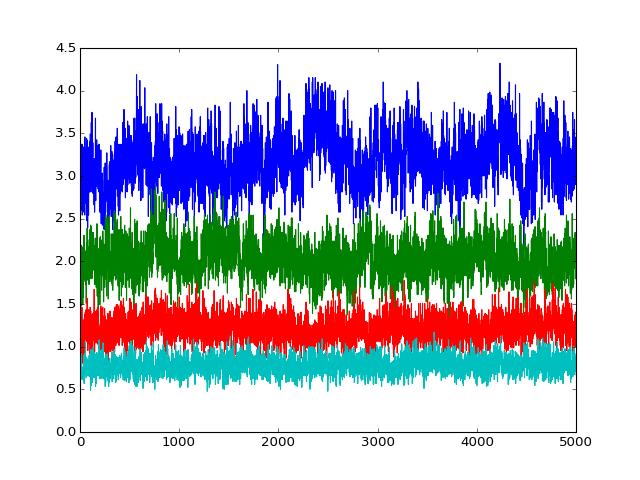

In [12]:
images_sets = (mask_data1, mask_data2)

mean_int_sets, index_list = roi.mean_intensity_sets(images_sets, rings_mask)
combine_intensity = roi.combine_mean_intensity(mean_int_sets, index_list)

plt.figure()
plt.plot(combine_intensity)
plt.show()

In [13]:
spe_cts_all.shape

NameError: name 'spe_cts_all' is not defined

In [23]:
mean_int_ring = np.mean(combine_intensity, axis=0)
mean_int_ring


array([ 3.17485961,  2.03201167,  1.22065947,  0.78540586])

In [47]:
images_sets = (mask_data1, mask_data2)

spe_cts_all, std_dev = xsvs2(images_sets, rings_mask, mean_int_rois=mean_int_ring, timebin_num=2,
                             number_of_img=50, max_cts=45)

In [24]:
num_times = 6
num_rois=num_rings
max_cts = 45
norm_bin_edges, norm_bin_centers = xsvs.normalize_bin_edges(num_times,
                                                            num_rois, mean_int_ring, max_cts)

In [14]:
norm_bin_centers[1,2].shape, spe_cts_all[1,2].shape, std_dev[1,2].shape, norm_bin_edges[1, 2][:-1].shape

((89,), (89,), (89,), (89,))

<IPython.core.display.Javascript object>


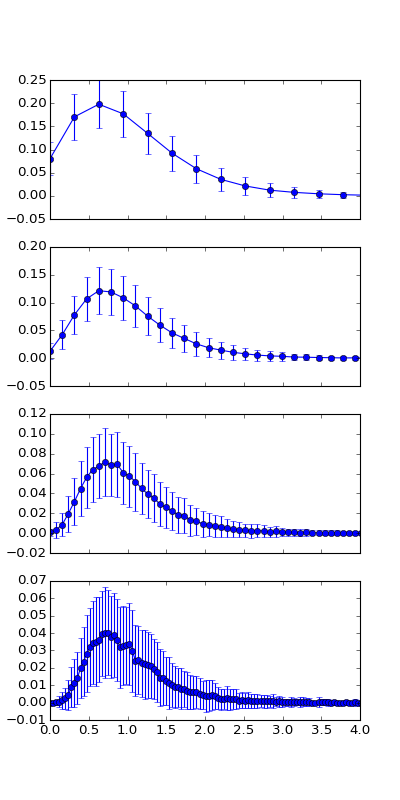

In [49]:
fig, axes = plt.subplots(4, sharex=True, figsize=(5,10))
#axes[6-1].set_xlabel("K/<K>")
for i in range(4):
    #axes[i].set_ylabel("speckle_counts") 
    #axes[i].errorbar(x[1:], spe_cts_all_2[i, 3], yerr=std_dev_2[i,3])
    axes[i].errorbar(norm_bin_edges[i, 0][:-1], spe_cts_all[i, 0], yerr=std_dev[i, 0],fmt='-o')
    axes[i].set_xlim(0, 4)   
plt.show()

<IPython.core.display.Javascript object>


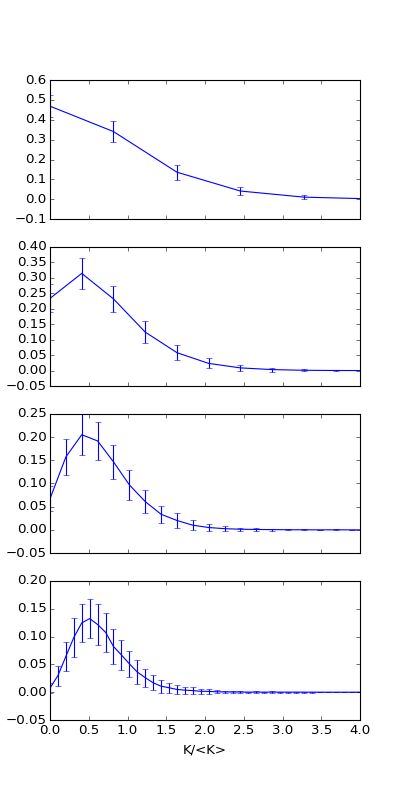

In [50]:
fig, axes = plt.subplots(4, sharex=True, figsize=(5,10))
axes[4-1].set_xlabel("K/<K>")
for i in range(4):
    #axes[i].set_ylabel("speckle_counts") 
    axes[i].errorbar(norm_bin_edges[i, 2][:-1], spe_cts_all[i, 3], yerr=std_dev[i,3])
    #axes[i].plot(norm_bin_edges[i, 2][:-1], spe_cts_all[i, 2],'-o')
    axes[i].set_xlim(0, 4)   
plt.show()

In [53]:
time_steps = core.geometric_series(2, 50)
time_steps

[1, 2, 4, 8, 16, 32]

# 1st q ring  0.0026859 (1/Angstroms)

<IPython.core.display.Javascript object>


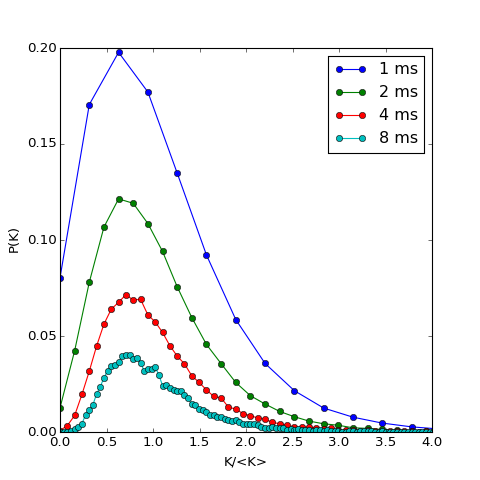

In [54]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(4):
    art, = axes.plot(norm_bin_edges[i, 0][:-1], spe_cts_all[i, 0], '-o', label=str(time_steps[i])+" ms")
    axes.set_xlim(0, 4)
    axes.legend()
plt.show()

# 2nd  q ring  0.00278726 (1/Angstroms)

<IPython.core.display.Javascript object>


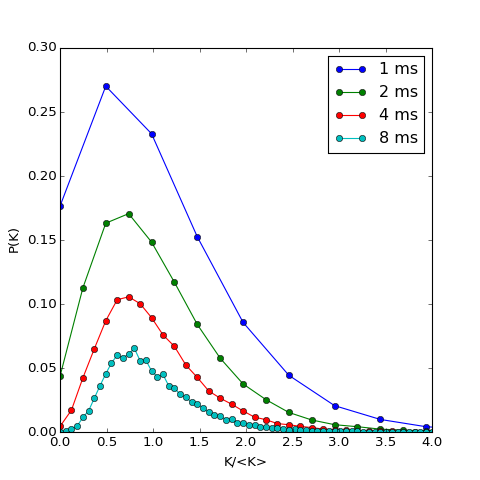

In [56]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(4):
    art, = axes.plot(norm_bin_edges[i, 1][:-1], spe_cts_all[i, 1], '-o', label=str(time_steps[i])+" ms")
    axes.legend()
    axes.set_xlim(0, 4)
plt.show()

# 3rd q ring 0.00288861 (1/ Angstroms)

<IPython.core.display.Javascript object>


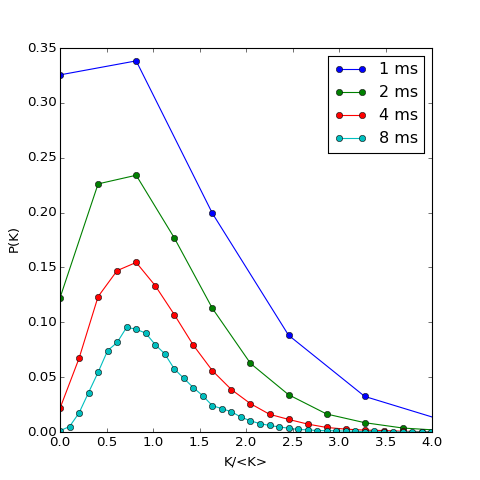

In [57]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(4):
    art, = axes.plot(norm_bin_edges[i, 2][:-1], spe_cts_all[i, 2], '-o', label=str(time_steps[i])+" ms" )
    axes.set_xlim(0, 4)
    axes.legend()
plt.show()

#  4th q ring 0.0298997 (1/ Angstroms)

/Users/sameera/mc/envs/work/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


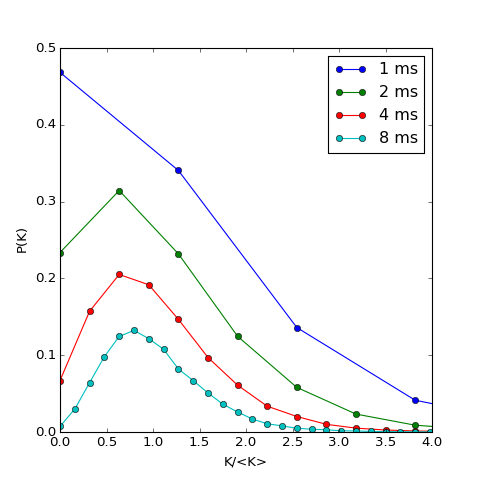

In [58]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(4):
    art, = axes.plot(norm_bin_edges[i, 3][:-1], spe_cts_all[i, 3], '-o', label=str(time_steps[i])+" ms")
    axes.set_xlim(0, 4)
    axes.legend()
plt.show()

In [55]:
images = []
for i in range(10):
        int_array = np.tril(i*np.ones(10))
        if i==10/2:
           int_array[int_array == 0] = 100
        else:
            int_array[int_array == 0] = (i+1)*2
        images.append(int_array)

images = np.asarray(images)

In [56]:
images

array([[[   2.,    2.,    2.,    2.,    2.,    2.,    2.,    2.,    2.,
            2.],
        [   2.,    2.,    2.,    2.,    2.,    2.,    2.,    2.,    2.,
            2.],
        [   2.,    2.,    2.,    2.,    2.,    2.,    2.,    2.,    2.,
            2.],
        [   2.,    2.,    2.,    2.,    2.,    2.,    2.,    2.,    2.,
            2.],
        [   2.,    2.,    2.,    2.,    2.,    2.,    2.,    2.,    2.,
            2.],
        [   2.,    2.,    2.,    2.,    2.,    2.,    2.,    2.,    2.,
            2.],
        [   2.,    2.,    2.,    2.,    2.,    2.,    2.,    2.,    2.,
            2.],
        [   2.,    2.,    2.,    2.,    2.,    2.,    2.,    2.,    2.,
            2.],
        [   2.,    2.,    2.,    2.,    2.,    2.,    2.,    2.,    2.,
            2.],
        [   2.,    2.,    2.,    2.,    2.,    2.,    2.,    2.,    2.,
            2.]],

       [[   1.,    4.,    4.,    4.,    4.,    4.,    4.,    4.,    4.,
            4.],
        [   1.,    